In [1]:
import os
import sys
import inspect
import itertools
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/jonesw/Downloads/dcc-detect-4e11a4adbc07.json'


import numpy as np
from numpy import ma
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from dateutil.parser import parse as parse_date
import cv2 as cv
from scipy import ndimage as ndi

import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import cartopy.crs as ccrs


# code from https://stackoverflow.com/questions/279237/import-a-module-from-a-relative-path?lq=1#comment15918105_6098238 to load a realitive folde from a notebook
# realpath() will make your script run, even if you symlink it :)
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

# from utils import io, abi, glm, nexrad
from utils import io, abi, glm, nexrad
from utils.plotting import goes_figure
from utils.flow import Flow
from utils import legacy_flow as lf

# Filter some warnings because pyart doesn't work nicely with notebooks

import warnings
warnings.filterwarnings(
    action='ignore',
    category=DeprecationWarning
)

import warnings
warnings.filterwarnings(
    action='ignore',
    category=UserWarning
)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Figure 1: Examples of growing, mature and dissipating convection in satellite, radar and lightning signature

In [2]:
# Load files
goes_data_path = './data/GOES16'
start_date = datetime(2018,6,19,17)
days = timedelta(days=0.16)
dates = pd.date_range(start_date, start_date+days, freq='H', closed='left').to_pydatetime()

abi_files = io.find_abi_files(dates, satellite=16, product='MCMIP', view='C', mode=3, 
                              save_dir=goes_data_path, 
                              replicate_path=True, check_download=True, 
                              n_attempts=1, download_missing=True)
             

abi_dates = [io.get_goes_date(i) for i in abi_files]
print(len(abi_files))

# Get time difference (in seconds) between each file
dt = [(abi_dates[1]-abi_dates[0]).total_seconds()/60] \
     + [(abi_dates[i+2]-abi_dates[i]).total_seconds()/120 \
        for i in range(len(abi_files)-2)] \
     + [(abi_dates[-1]-abi_dates[-2]).total_seconds()/60]
dt = np.array(dt)

# Test with some multichannel data
ds_slice = {'x':slice(1325,1475), 'y':slice(725,850)}
# Load a stack of goes datasets using xarray. Select a region over Northern Florida. (full file size in 1500x2500 pixels)
goes_ds = xr.open_mfdataset(abi_files, concat_dim='t', combine='nested').isel(ds_slice)

48


In [3]:
# Extract fields and load into memory
wvd = goes_ds.CMI_C08 - goes_ds.CMI_C10
try:
    wvd = wvd.compute()
except AttributeError:
    pass

bt = goes_ds.CMI_C13
try:
    bt = bt.compute()
except AttributeError:
    pass

swd = goes_ds.CMI_C13 - goes_ds.CMI_C15
try:
    swd = swd.compute()
except AttributeError:
    pass

In [4]:
# Get GLM data
# Process new GLM data
glm_files = io.find_glm_files(dates, satellite=16,
                              save_dir=goes_data_path,
                              replicate_path=True, check_download=True,
                              n_attempts=1, download_missing=True)
glm_files = {io.get_goes_date(i):i for i in glm_files}
glm_grid = glm.regrid_glm(glm_files, goes_ds, corrected=False)

In [5]:
h = goes_ds.goes_imager_projection.perspective_point_height
glm_xy = [[np.concatenate(locs)*h for locs in zip(*[glm.get_uncorrected_glm_x_y(glm_files[ft], goes_ds)
                                                  for ft in glm_files 
                                                  if ft >= abi_dates[i]-timedelta(minutes=2.5) 
                                                      and ft < abi_dates[i]+timedelta(minutes=2.5)])]
         for i in [0,6,18,-1]]

In [6]:
# Get Nexrad data
nexrad_data_path = './data/nexrad_l2'
print('Finding NEXRAD data')
nexrad_sites = nexrad.filter_nexrad_sites(goes_ds,extend=0.001)
print("Number of sites in bound: %d" % len(nexrad_sites))
nexrad_files = sum([sum([io.find_nexrad_files(date, site, save_dir=nexrad_data_path, download_missing=True)
                         for site in nexrad_sites], [])
                    for date in dates], [])

Finding NEXRAD data
Number of sites in bound: 3


In [7]:
# Regrid nexrad - note that this is a lengthly operation, expect it to take ~1 hour for the example here
# TODO; make pre-processed regridded nexrad file available.
ref_grid, ref_mask = nexrad.regrid_nexrad(nexrad_files, goes_ds, min_alt=500)

2021-03-26 01:23:24.203764 ./data/nexrad_l2/2018/06/19/KTLH/NWS_NEXRAD_NXL2DPBL_KTLH_20180619170000_20180619175959.tar
2021-03-26 01:27:13.815088 ./data/nexrad_l2/2018/06/19/KTBW/NWS_NEXRAD_NXL2DPBL_KTBW_20180619170000_20180619175959.tar
2021-03-26 01:30:28.815331 ./data/nexrad_l2/2018/06/19/KTLH/NWS_NEXRAD_NXL2DPBL_KTLH_20180619180000_20180619185959.tar
2021-03-26 01:34:05.592214 ./data/nexrad_l2/2018/06/19/KTBW/NWS_NEXRAD_NXL2DPBL_KTBW_20180619180000_20180619185959.tar
2021-03-26 01:36:58.566576 ./data/nexrad_l2/2018/06/19/KVAX/NWS_NEXRAD_NXL2DPBL_KVAX_20180619190000_20180619195959.tar
2021-03-26 01:37:20.697812 ./data/nexrad_l2/2018/06/19/KTLH/NWS_NEXRAD_NXL2DPBL_KTLH_20180619190000_20180619195959.tar
2021-03-26 01:40:26.266988 ./data/nexrad_l2/2018/06/19/KTBW/NWS_NEXRAD_NXL2DPBL_KTBW_20180619190000_20180619195959.tar
2021-03-26 01:42:57.909670 ./data/nexrad_l2/2018/06/19/KVAX/NWS_NEXRAD_NXL2DPBL_KVAX_20180619200000_20180619205959.tar
2021-03-26 01:45:18.449306 ./data/nexrad_l2/2018

/Users/jonesw/python/example_notebooks/utils/nexrad.py:157: RuntimeWarning: invalid value encountered in true_divide
  ref_grid = ref_total/ref_counts_masked


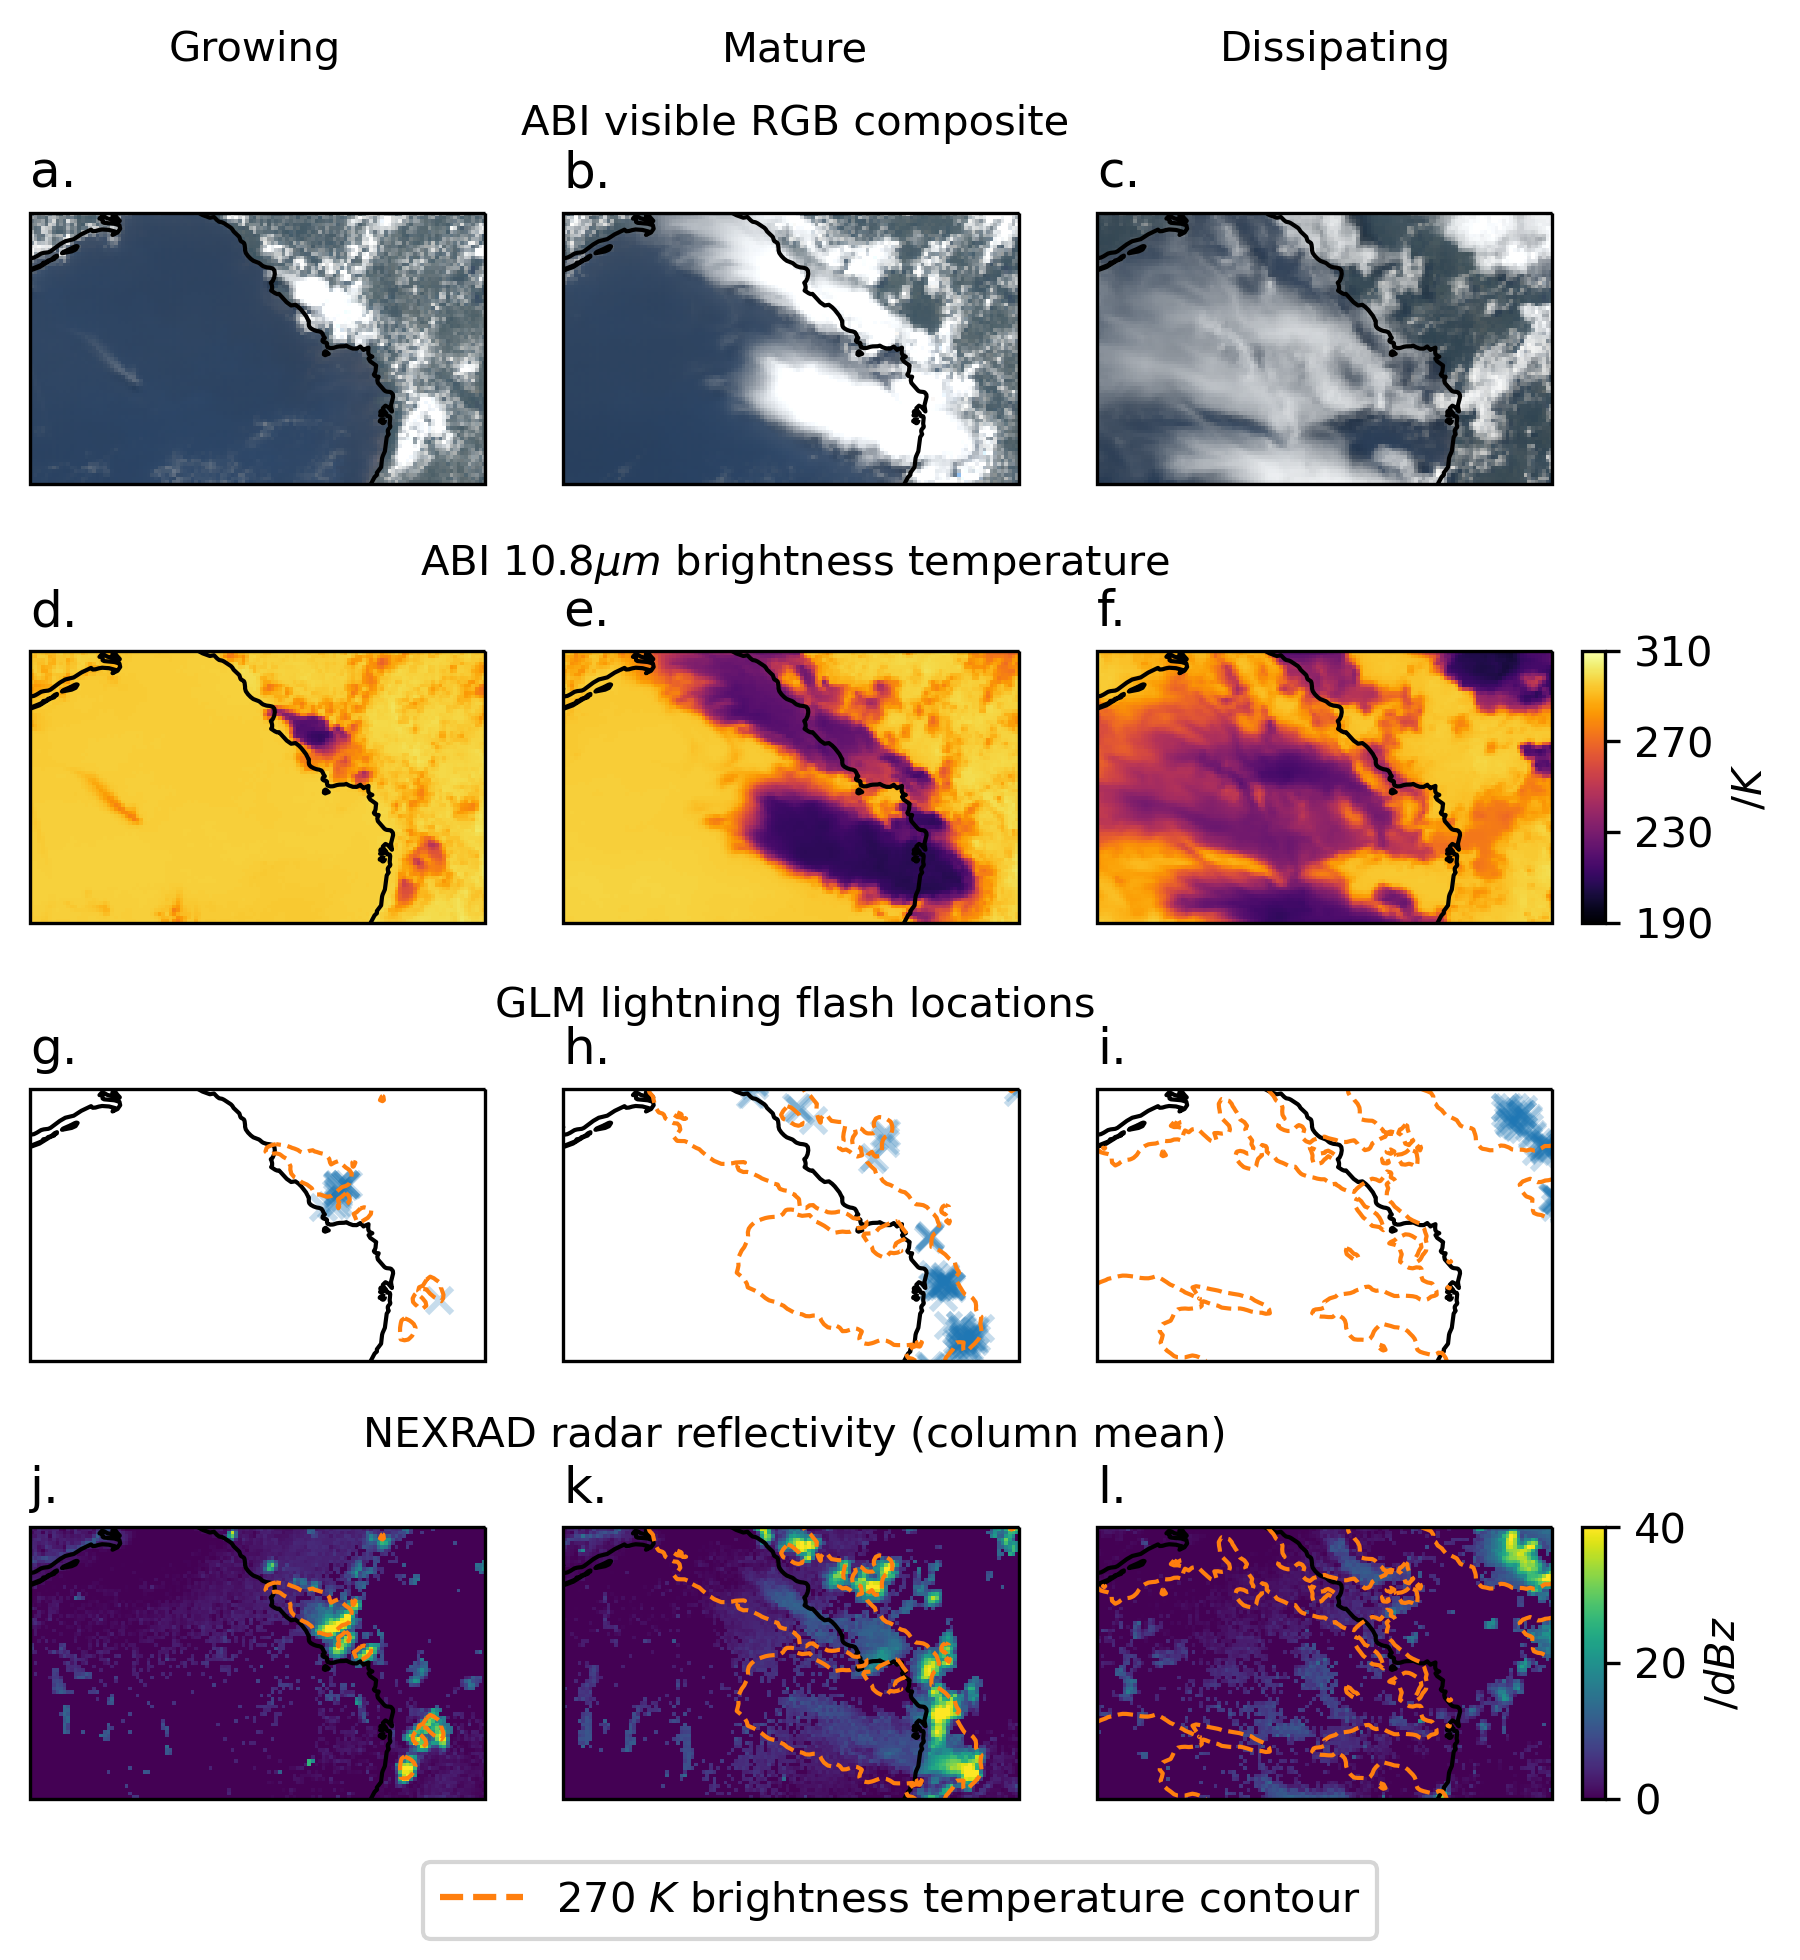

In [10]:
fig = goes_figure(goes_ds.isel({'y':slice(25,-25), 'x':slice(25,None)}), dpi=300, figsize=(6,7))

ax1 = fig.subplot(431)
ax1.coastlines()
ax1.imshow(abi.get_abi_rgb(goes_ds.isel({'t':0}))[25:-25, 25:])
ax1.set_title('a.', loc='left')
# ax1.set_title('Growing')

ax2 = fig.subplot(432)
ax2.coastlines()
ax2.imshow(abi.get_abi_rgb(goes_ds.isel({'t':18}))[25:-25, 25:])
ax2.set_title('b.', loc='left')
# ax2.set_title('Mature')

ax3 = fig.subplot(433)
ax3.coastlines()
ax3.imshow(abi.get_abi_rgb(goes_ds.isel({'t':-1}))[25:-25, 25:])
ax3.set_title('c.', loc='left')
# ax3.set_title('Dissipating')

ax4 = fig.subplot(434)
ax4.coastlines()
ax4.imshow(goes_ds.CMI_C13[0][25:-25, 25:], vmin=190, vmax=310, cmap='inferno')
ax4.set_title('d.', loc='left')

ax5 = fig.subplot(435)
ax5.coastlines()
ax5.imshow(goes_ds.CMI_C13[18][25:-25, 25:], vmin=190, vmax=310, cmap='inferno')
ax5.set_title('e.', loc='left')

ax6 = fig.subplot(436)
ax6.coastlines()
img = ax6.imshow(goes_ds.CMI_C13[-1][25:-25, 25:], vmin=190, vmax=310, cmap='inferno')
cbar = ax6.colorbar(img)
cbar.set_label('/$K$')
cbar.set_ticks([190,230,270,310])
ax6.set_title('f.', loc='left')

ax7 = fig.subplot(437)
ax7.coastlines()
ax7.set_title('g.', loc='left')
ax7.contour(goes_ds.isel({'t':0}).CMI_C13[25:-25, 25:], [270], colors=['C01'], linestyles=['--'], linewidths=1)
ax7.scatter(glm_xy[0][0], glm_xy[0][1], c=['C00'], marker='x', alpha=0.25)

ax8 = fig.subplot(438)
ax8.coastlines()
ax8.set_title('h.', loc='left')
ax8.contour(goes_ds.isel({'t':18}).CMI_C13[25:-25, 25:], [270], colors=['C01'], linestyles=['--'], linewidths=1)
ax8.scatter(glm_xy[2][0], glm_xy[2][1], c=['C00'], marker='x', alpha=0.25)

ax9 = fig.subplot(439)
ax9.coastlines()
ax9.set_title('i.', loc='left')
ax9.contour(goes_ds.isel({'t':-1}).CMI_C13[25:-25, 25:], [270], colors=['C01'], linestyles=['--'], linewidths=1)
ax9.scatter(glm_xy[3][0], glm_xy[3][1], c=['C00'], marker='x', alpha=0.25)

ax10 = fig.subplot(4, 3, 10)
ax10.coastlines()
ax10.set_title('j.', loc='left')
ax10.contour(goes_ds.isel({'t':0}).CMI_C13[25:-25, 25:], [270], colors=['C01'], linestyles=['--'], linewidths=1)
ax10.imshow(ref_grid[0][25:-25, 25:], vmin=0, vmax=40)

ax11 = fig.subplot(4, 3, 11)
ax11.coastlines()
ax11.set_title('k.', loc='left')
ax11.contour(goes_ds.isel({'t':18}).CMI_C13[25:-25, 25:], [270], colors=['C01'], linestyles=['--'], linewidths=1)
ax11.imshow(ref_grid[18][25:-25, 25:], vmin=0, vmax=40)

ax12 = fig.subplot(4, 3, 12)
ax12.coastlines()
ax12.set_title('l.', loc='left')
ax12.contour(goes_ds.isel({'t':-1}).CMI_C13[25:-25, 25:], [270], colors=['C01'], linestyles=['--'], linewidths=1)
img2 = ax12.imshow(ref_grid[-1][25:-25, 25:], vmin=0, vmax=40)
cbar2 = ax12.colorbar(img2)
cbar2.set_label('/$dBz$')
# cbar2.set_ticks([180,220,260,300])

import matplotlib.lines as mlines
fig.legend([mlines.Line2D([], [], color='C01', linestyle='--')], 
           ['270 $K$ brightness temperature contour'], loc='lower center')

fig.text(0.5, 0.24, 'NEXRAD radar reflectivity (column mean)', ha='center', va='baseline')

fig.text(0.5, 0.445, 'GLM lightning flash locations', ha='center', va='baseline')

fig.text(0.5, 0.655, 'ABI 10.8$\mu m$ brightness temperature', ha='center', va='baseline')

fig.text(0.5, 0.865, 'ABI visible RGB composite', ha='center', va='baseline')

fig.text(0.5, 0.9, 'Mature', ha='center', va='baseline')
fig.text(0.2, 0.9, 'Growing', ha='center', va='baseline')
fig.text(0.8, 0.9, 'Dissipating', ha='center', va='baseline')


plt.subplots_adjust(wspace=0.05, bottom=0.05, top=0.85, left=0.075, right=0.95)

Figure 2: DCC cross section in horizontal distance and time for satellite BT and radar reflectivity

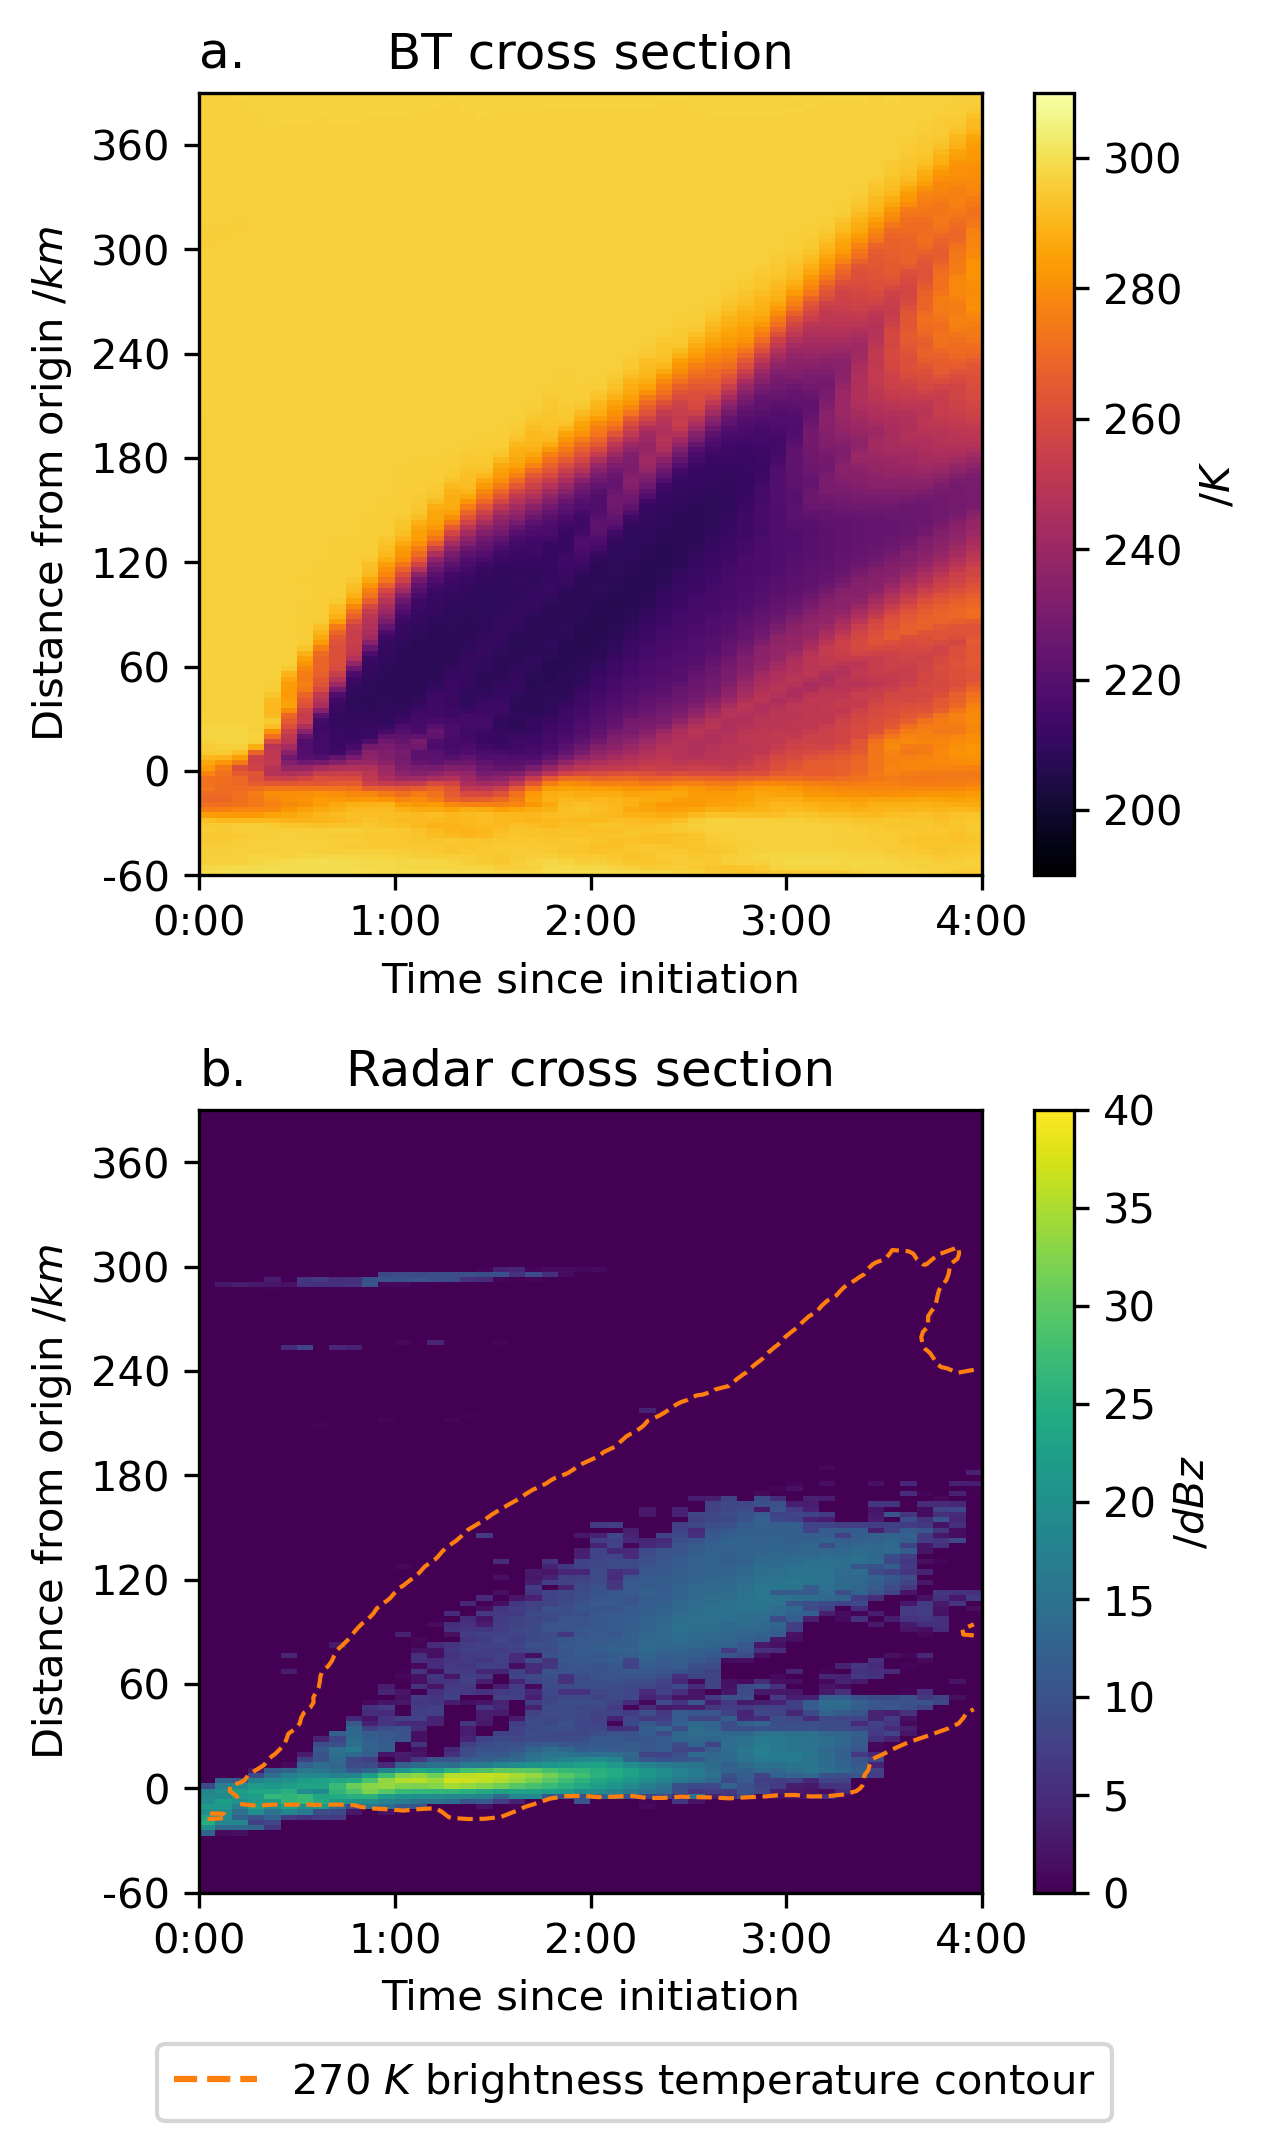

In [231]:
fig = plt.figure(dpi=300, figsize=(4,8))

plt.subplot(211)
plt.imshow(bt[:,75:85].mean('y').T, cmap='inferno', vmin=190, vmax=310, aspect=48/150, origin='upper')
cbar = plt.colorbar()
cbar.set_label('/$K$')

# plt.contour(wvd_growth[:,75:85].mean(1).T, [0.25], colors=['C00'], linewidths=[2])
plt.xticks([-0.5,11.5,23.5,35.5,47.5], labels=['0:00', '1:00', '2:00', '3:00', '4:00'])
# plt.yticks([])
plt.yticks(np.arange(149.5,0,-20), labels=range(-60,405,60))
plt.title('a.', loc='left')
plt.ylabel('Distance from origin /$km$')
plt.xlabel('Time since initiation')
plt.title('BT cross section')

plt.subplot(212)
plt.imshow(ref_grid[:,75:85].mean('y').T, vmin=0, vmax=40, aspect=48/150, origin='upper')
cbar = plt.colorbar()
cbar.set_label('/$dBz$')
plt.contour(bt[:,75:85].mean('y').T, [270], colors=['C01'], linestyles=['--'], linewidths=[1])
plt.xticks([-0.5,11.5,23.5,35.5,47.5], labels=['0:00', '1:00', '2:00', '3:00', '4:00'])
# plt.yticks([])
plt.title('b.', loc='left')
plt.yticks(np.arange(149.5,0,-20), labels=range(-60,405,60))
plt.ylabel('Distance from origin /$km$')
plt.xlabel('Time since initiation')
plt.title('Radar cross section')

import matplotlib.lines as mlines
fig.legend([mlines.Line2D([], [], color='C01', linestyle='--')], 
           ['270 $K$ brightness temperature contour'], loc='lower center')

plt.subplots_adjust(hspace=0.3, bottom=0.1, top=0.85, left=0.075, right=0.95)

Figure 3: GOES ABI imagery for channel 13, WVD, and SWD combinations

Text(0.5, 1.0, 'Split Window Difference')

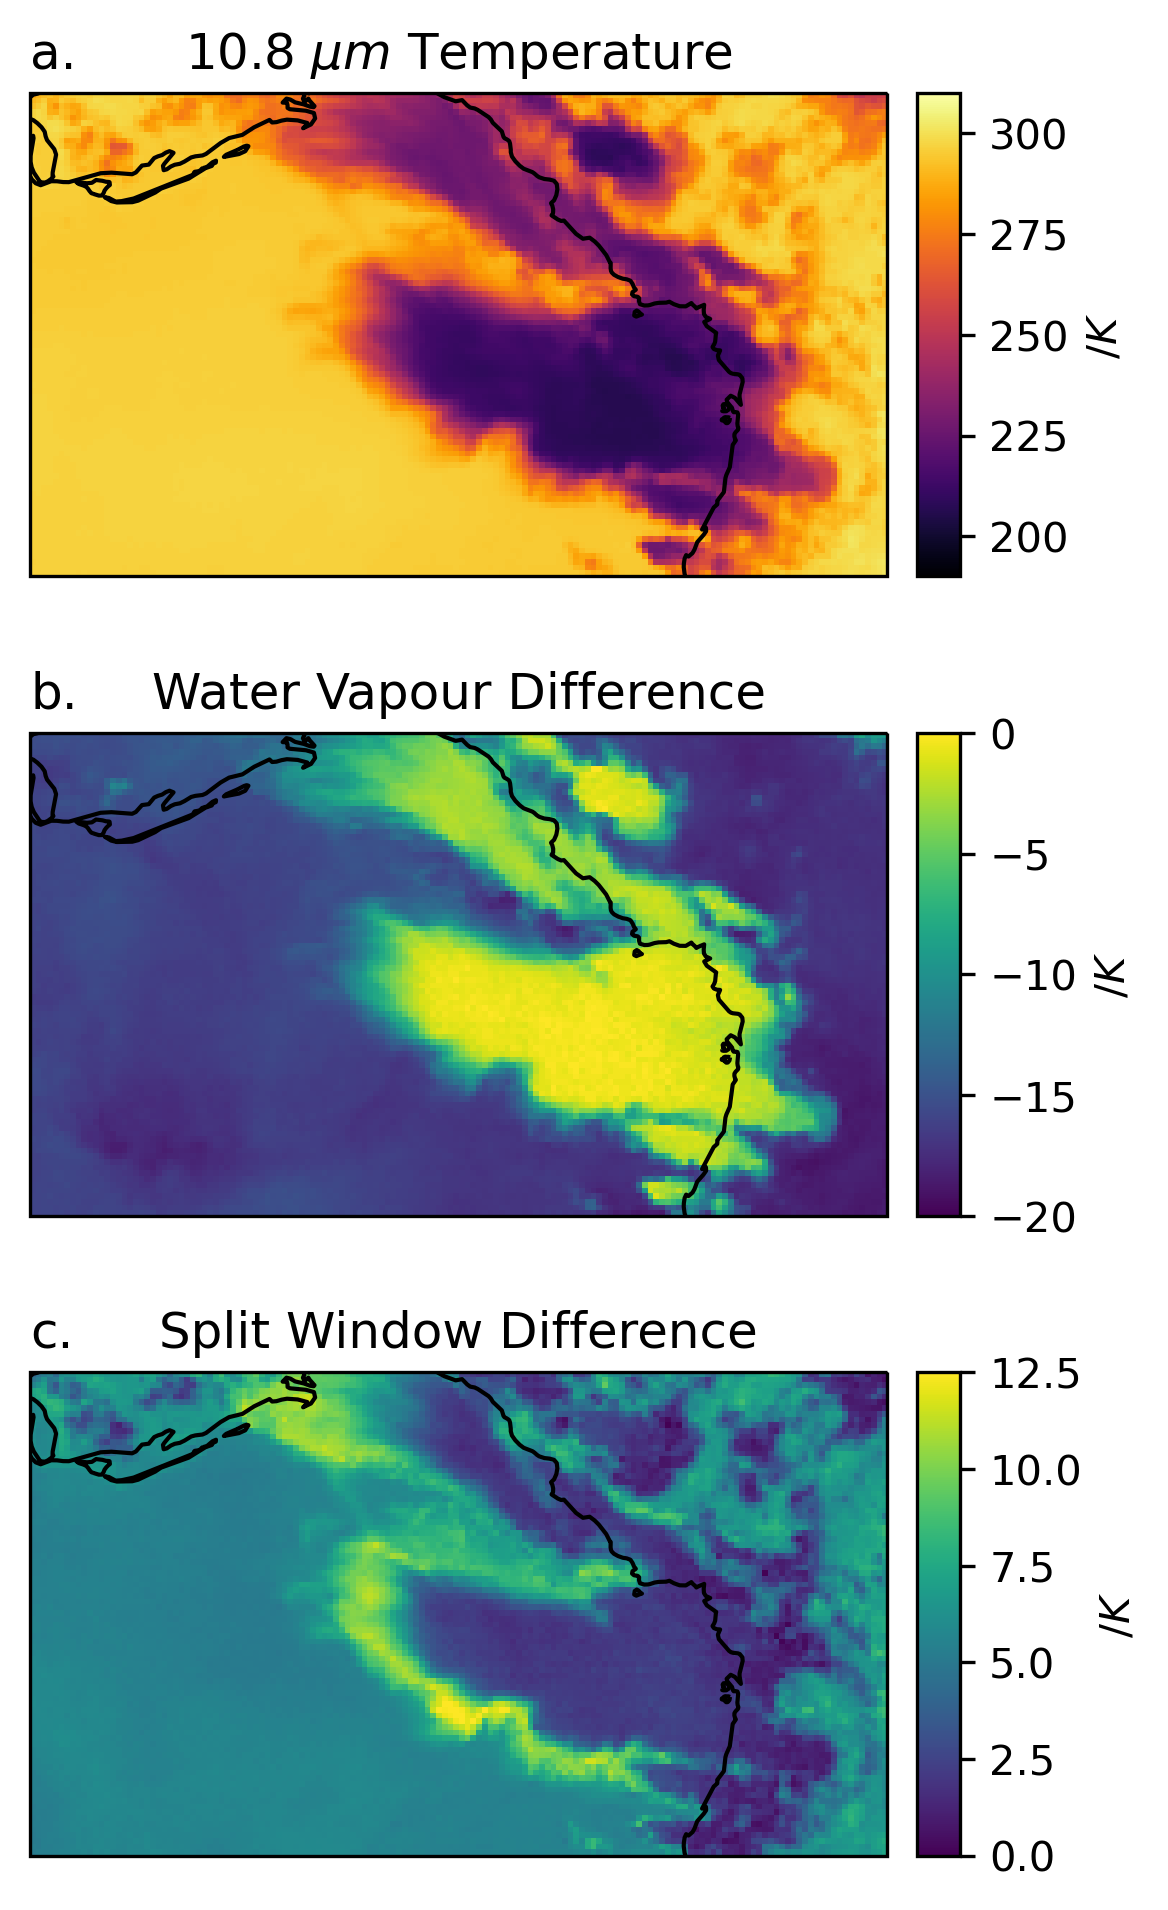

In [222]:
fig = goes_figure(goes_ds.isel({'y':slice(25,-15)}), dpi=300, figsize=(4,8))

ax1 = fig.subplot(311)
ax1.coastlines()
im1 = ax1.imshow(bt[24,25:-15], cmap='inferno', vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('/$K$')
# cbar1.set_ticks([190,230,270,310])
ax1.set_title('a.', loc='left')
ax1.set_title('10.8 $\mu m$ Temperature')

ax2 = fig.subplot(312)
ax2.coastlines()
im2 = ax2.imshow(wvd[24,25:-15], vmin=-20, vmax=0)
cbar2 = ax2.colorbar(im2)
cbar2.set_label('/$K$')
ax2.set_title('b.', loc='left')
ax2.set_title('Water Vapour Difference')

ax3 = fig.subplot(313)
ax3.coastlines()
im3 = ax3.imshow(swd[24,25:-15], vmin=0, vmax=12.5)
cbar3 = ax3.colorbar(im3)
cbar3.set_label('/$K$')
ax3.set_title('c.', loc='left')
ax3.set_title('Split Window Difference')


Figure 4: Optical flow vector examples

In [83]:
flow_kwargs = {'pyr_scale':0.5, 'levels':5, 'winsize':16, 'iterations':3, 
               'poly_n':5, 'poly_sigma':1.1, 'flags':cv.OPTFLOW_FARNEBACK_GAUSSIAN}

flow = Flow(bt, flow_kwargs=flow_kwargs, smoothing_passes=3)

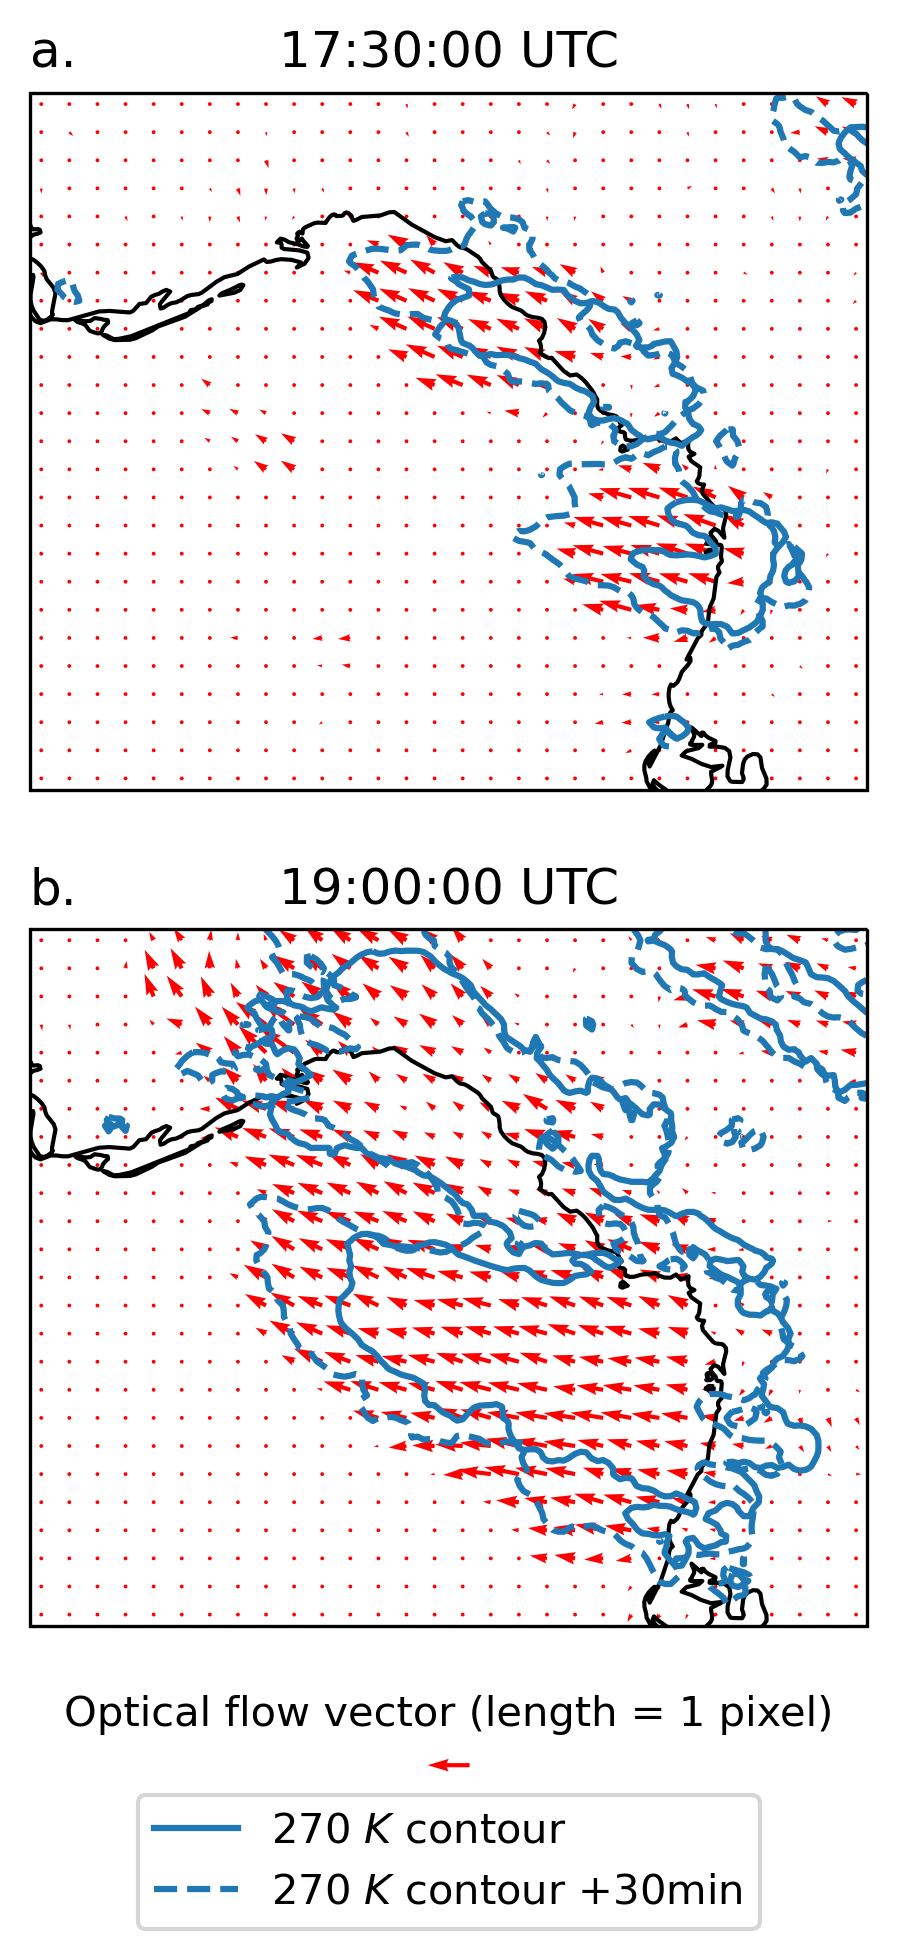

In [252]:
fig = goes_figure(goes_ds, dpi=300, figsize=(4,7))
i=6
ax1 = fig.subplot(211)
# ax1.imshow(abi.get_abi_rgb(goes_ds.isel({'t':18})))
ax1.coastlines()
ax1.contour(goes_ds.isel({'t':i}).CMI_C13, [270], colors=['C00'])
ax1.contour(goes_ds.isel({'t':i+6}).CMI_C13, [270], colors=['C00'], linestyles=['--'])
ax1.quiver(flow.flow_for[i,...,0],-flow.flow_for[i,...,1], spacing=5, scale=100, width=0.005, color='r')
ax1.set_title('a.', loc='left')
ax1.set_title('17:30:00 UTC')

ax2 = fig.subplot(212)
i=24
# img2 = ax2.imshow(goes_ds.isel({'t':30}).CMI_C13, cmap='inferno')
ax2.coastlines()
# cbar2 = ax2.colorbar(img2)
# cbar2.set_label('Brightness temperature /K')
ax2.contour(goes_ds.isel({'t':i}).CMI_C13, [270], colors=['C00'])
ax2.contour(goes_ds.isel({'t':i+6}).CMI_C13, [270], colors=['C00'], linestyles=['--'])
q = ax2.quiver(flow.flow_for[i,...,0],-flow.flow_for[i,...,1], spacing=5, scale=100, width=0.005, color='r')
ax2.set_title('b.', loc='left')
ax2.set_title('19:00:00 UTC')

plt.quiverkey(q, 0.5, -0.2, 5, 'Optical flow vector (length = 1 pixel)', angle=180, coordinates='axes')
fig.legend([mlines.Line2D([], [], color='C00'),mlines.Line2D([], [], color='C00', linestyle='--')], 
           ['270 $K$ contour', '270 $K$ contour +30min'], loc='lower center')

plt.subplots_adjust(bottom=0.15)

Figure 5: Lagrangian convolution kernel

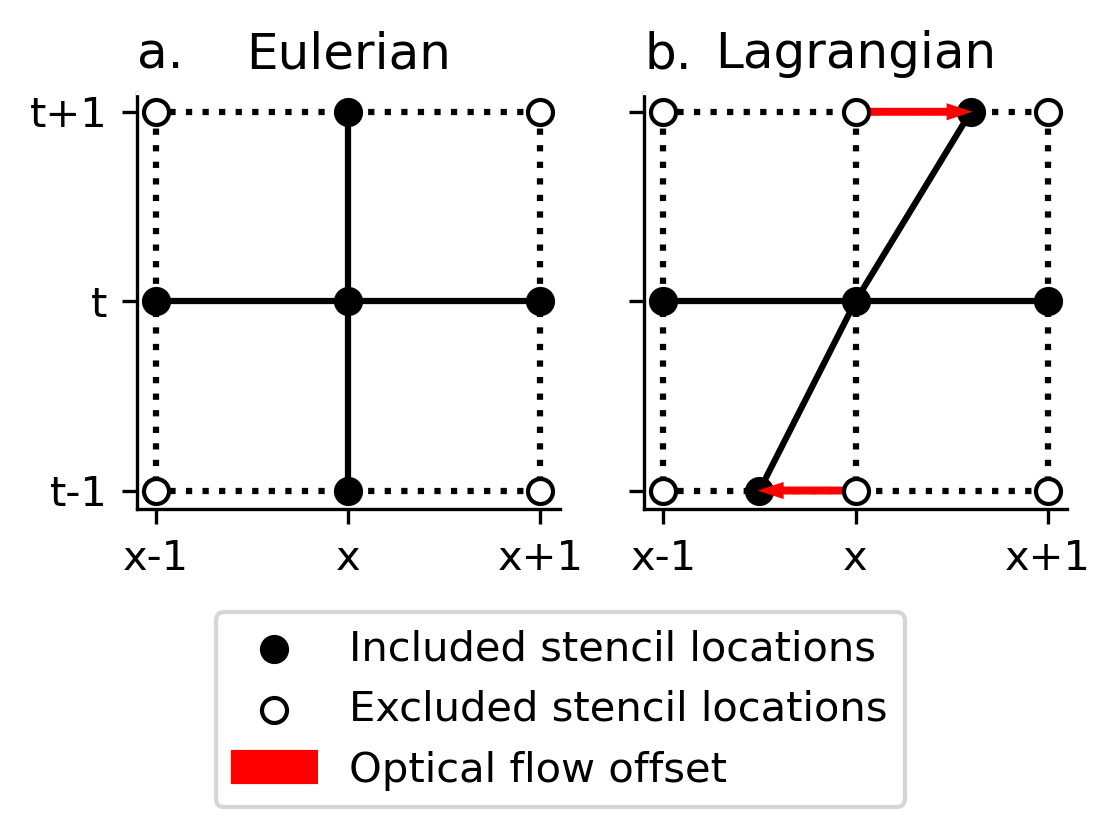

In [244]:
fig = plt.figure(dpi=300, figsize=(4,2.75))

ax1 = plt.subplot(121)
ax1.spines['top'].set_color('white')
ax1.spines['right'].set_color('white')
plt.plot([1,-1],[0,0],'k-')
plt.plot([0,0],[1,-1],'k-')
plt.plot([1,-1],[1,1],'k:')
plt.plot([1,-1],[-1,-1],'k:')
plt.plot([1,1],[1,-1],'k:')
plt.plot([-1,-1],[1,-1],'k:')

include_points = plt.scatter([0,0,0,1,-1],[-1,0,1,0,0], c='k', zorder=3)
exclude_points = plt.scatter([1,1,-1,-1],[1,-1,-1,1], c='white', edgecolors='k', zorder=5)

plt.xticks([-1,0,1], labels=['x-1', 'x', 'x+1'])
plt.yticks([-1,0,1], labels=['t-1', 't', 't+1'])

plt.title('a.', loc='left')
plt.title('Eulerian')

plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])

ax2 = plt.subplot(122)
ax2.spines['top'].set_color('white')
ax2.spines['right'].set_color('white')
plt.plot([1,-1],[0,0],'k-')
plt.plot([0.6,0,-0.5],[1,0,-1],'k-')
plt.plot([0,0],[1,-1],'k:')
plt.plot([1,-1],[1,1],'k:')
plt.plot([1,-1],[-1,-1],'k:')
plt.plot([1,1],[1,-1],'k:')
plt.plot([-1,-1],[1,-1],'k:')

plt.scatter([-0.5,0,0.6,1,-1],[-1,0,1,0,0], c='k', zorder=3)
plt.scatter([1,1,-1,-1,0,0],[1,-1,-1,1,1,-1], c='white', edgecolors='k', zorder=5)

offset_arrow = plt.arrow(0,-1,-0.475,0,color='r',zorder=4, width=0.02, length_includes_head=True)
plt.arrow(0,1,0.575,0,color='r',zorder=4, width=0.02, length_includes_head=True)

plt.xticks([-1,0,1], labels=['x-1', 'x', 'x+1'])
plt.yticks([-1,0,1], labels=['', '', ''])

plt.title('b.', loc='left')
plt.title('Lagrangian')

plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])

fig.legend([include_points, exclude_points, offset_arrow], 
           ['Included stencil locations', 'Excluded stencil locations', 'Optical flow offset'], 
           loc='lower center')

plt.subplots_adjust(bottom=0.375)

Figure 6: Detection of growing deep convection

In [91]:
from utils import detection; reload(detection)

<module 'utils.detection' from '/Users/jonesw/python/example_notebooks/utils/detection.py'>

In [92]:
# Get growth_rate of the wvd field and find markers
from utils.detection import detect_growth_markers
wvd_growth, growth_markers = detect_growth_markers(flow, wvd)

/Users/jonesw/python/example_notebooks/utils/legacy_flow.py:136: RuntimeWarning: All-NaN axis encountered
  out_arr[t] = function(temp, 0, **kwargs)


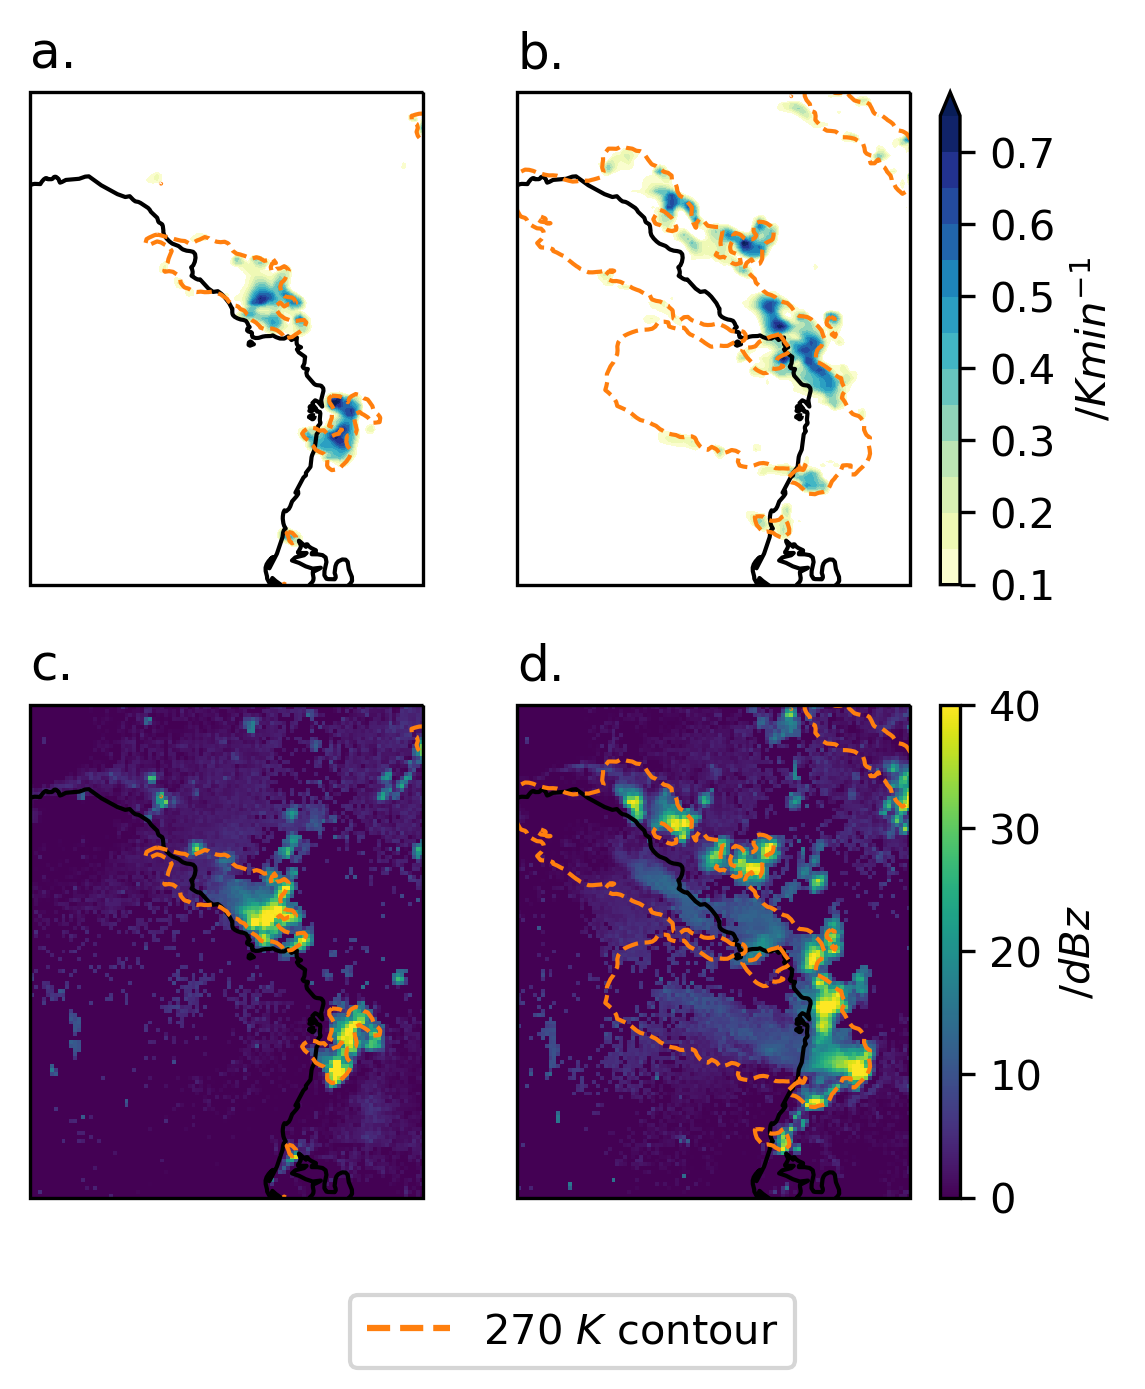

In [93]:
fig = goes_figure(goes_ds.isel({'x':slice(50,None)}), dpi=300, figsize=(4,5))
i1=3
ax1 = fig.subplot(221)
ax1.coastlines()
ax1.contour(goes_ds.isel({'t':i1}).CMI_C13[:,50:], [270], colors=['C01'], linestyles=['--'], linewidths=[1])
c1 = ax1.contourf(wvd_growth[i1][:,50:], np.arange(0.1,0.8,0.05), extend='max', cmap='YlGnBu')
ax1.set_title('a.', loc='left')
# ax1.set_title('17:15:00')

# cbar = ax1.colorbar(c1)
# cbar.set_label('/$K min^{-1}$')

ax2 = fig.subplot(222)
i2=18
ax2.coastlines()
ax2.contour(goes_ds.isel({'t':i2}).CMI_C13[:,50:], [270], colors=['C01'], linestyles=['--'], linewidths=[1])
c2 = ax2.contourf(wvd_growth[i2][:,50:], np.arange(0.1,0.8,0.05), extend='max', cmap='YlGnBu')
ax2.set_title('b.', loc='left')
# ax2.set_title('19:00:00')

cbar = ax2.colorbar(c2)
cbar.set_label('/$K min^{-1}$')

ax3 = fig.subplot(223)
ax3.coastlines()
ax3.set_title('c.', loc='left')
ax3.contour(goes_ds.isel({'t':i1}).CMI_C13[:,50:], [270], colors=['C01'], linestyles=['--'], linewidths=1)
ax3.imshow(ref_grid[i1][:,50:], vmin=0, vmax=40)

ax4 = fig.subplot(224)
ax4.coastlines()
ax4.set_title('d.', loc='left')
ax4.contour(goes_ds.isel({'t':i2}).CMI_C13[:,50:], [270], colors=['C01'], linestyles=['--'], linewidths=1)
img4 = ax4.imshow(ref_grid[i2][:,50:], vmin=0, vmax=40)

cbar2 = ax4.colorbar(img4)
cbar2.set_label('/$dBz$')

fig.legend([mlines.Line2D([], [], color='C01', linestyle='--')], 
           ['270 $K$ contour'], loc='lower center')

plt.subplots_adjust(bottom=0.1, hspace=0.1, wspace=0.1)

In [73]:
print('Growth above threshold: area =', np.sum(wvd_growth.data>=0.5))
print('Detected markers: area =', np.sum(growth_markers.data!=0))
print('Detected markers: n =', growth_markers.data.max())


Growth above threshold: area = 219
Detected markers: area = 223
Detected markers: n = 1


In [8]:
erode_struct = ndi.generate_binary_structure(2,1)[np.newaxis]
markers = ndi.binary_opening(temp_diff>=0.5, structure=erode_struct)
mask = ndi.binary_erosion((wvd<=-15).data.compute(), structure=erode_struct)

In [28]:
upper_threshold=-5
lower_threshold=-15
inner_field = wvd-swd+np.maximum(wvd_growth,0)*5

inner_field = np.maximum(np.minimum(inner_field, upper_threshold), lower_threshold)
inner_field.data[growth_markers!=0] = upper_threshold
inner_edges = flow.sobel(inner_field, direction='uphill')

Text(0.5, 1.0, 'Detected edges')

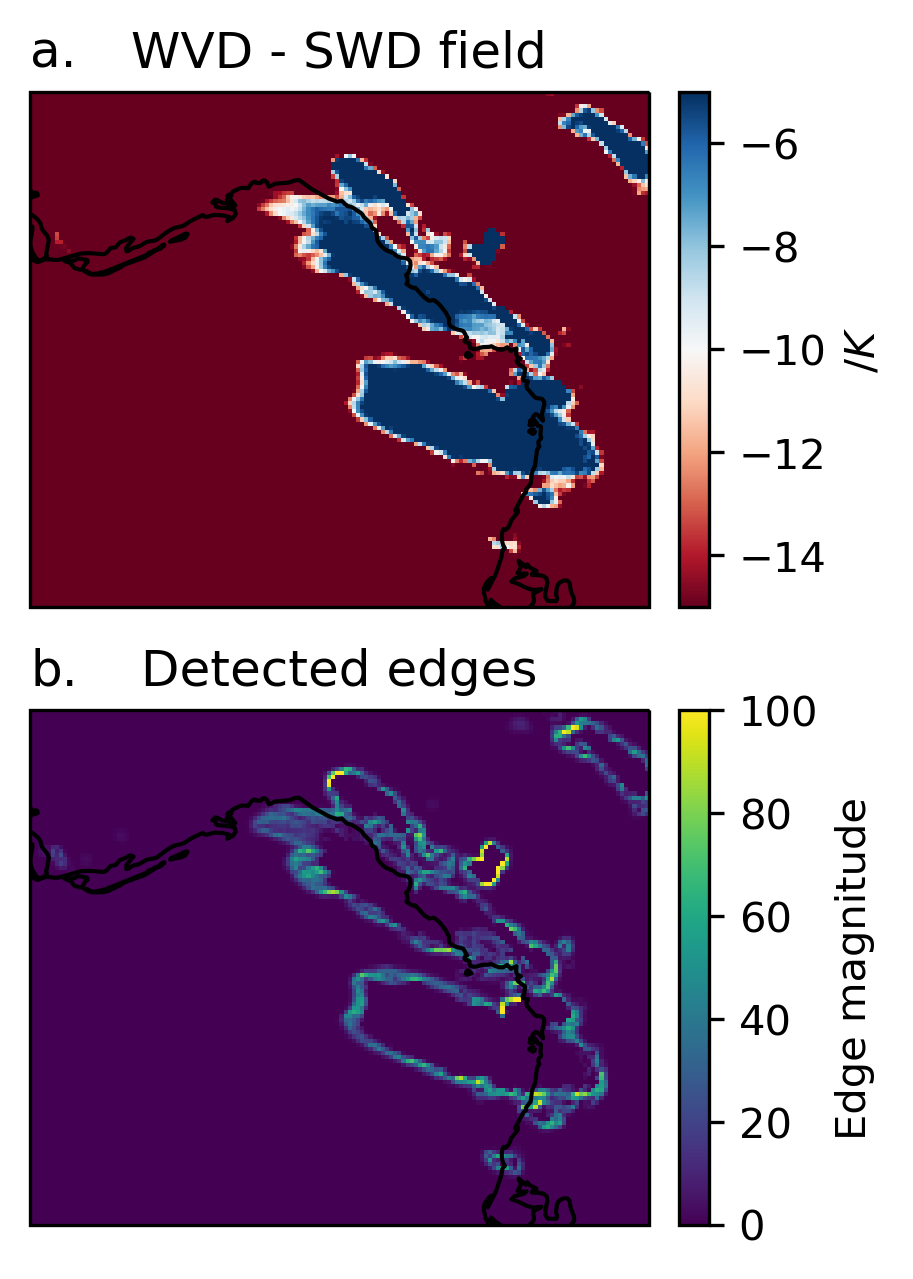

In [261]:
fig = goes_figure(goes_ds, dpi=300, figsize=(4,5))

ax1 = fig.subplot(211)
ax1.coastlines()
img1 = ax1.imshow(inner_field[18], vmin=-15, vmax=-5, cmap='RdBu')
cbar = ax1.colorbar(img1)
cbar.set_label('/$K$')
cbar.ax.set_yticks([-5,-7.5,-10.,-12.5,-15])
ax1.set_title('a.', loc='left')
ax1.set_title('WVD - SWD field')


ax2 = fig.subplot(212)
ax2.coastlines()
img2 = ax2.imshow(inner_edges[18], vmin=0, vmax=100)
cbar = ax2.colorbar(img2)
cbar.set_label('Edge magnitude')
ax2.set_title('b.', loc='left')
ax2.set_title('Detected edges')

# plt.imshow(inner_edges[18])

Figure 8: Detected anvil area

In [34]:
# Watershed anvil regions connected to growth markers
from utils.detection import edge_watershed
inner_watershed = edge_watershed(flow, wvd-swd+np.maximum(wvd_growth,0)*5, growth_markers!=0, -5, -15)


In [35]:
inner_labels = filter_labels_by_length_and_mask(flow.label(inner_watershed.data), growth_markers.data!=0, 3)
print('Detected anvils: area =', np.sum(inner_labels!=0))
print('Detected anvils: n =', inner_labels.max())


/Users/jonesw/python/example_notebooks/utils/legacy_flow.py:136: RuntimeWarning: All-NaN axis encountered
  out_arr[t] = function(temp, 0, **kwargs)


Detected anvils: area = 144383
Detected anvils: n = 2


In [215]:
outer_watershed = edge_watershed(flow, wvd+swd+np.maximum(wvd_growth,0)*5, inner_labels, 0, -7.5)
print('Detected thin anvils: area =', np.sum(outer_watershed!=0))


Detected thin anvils: area = 239812


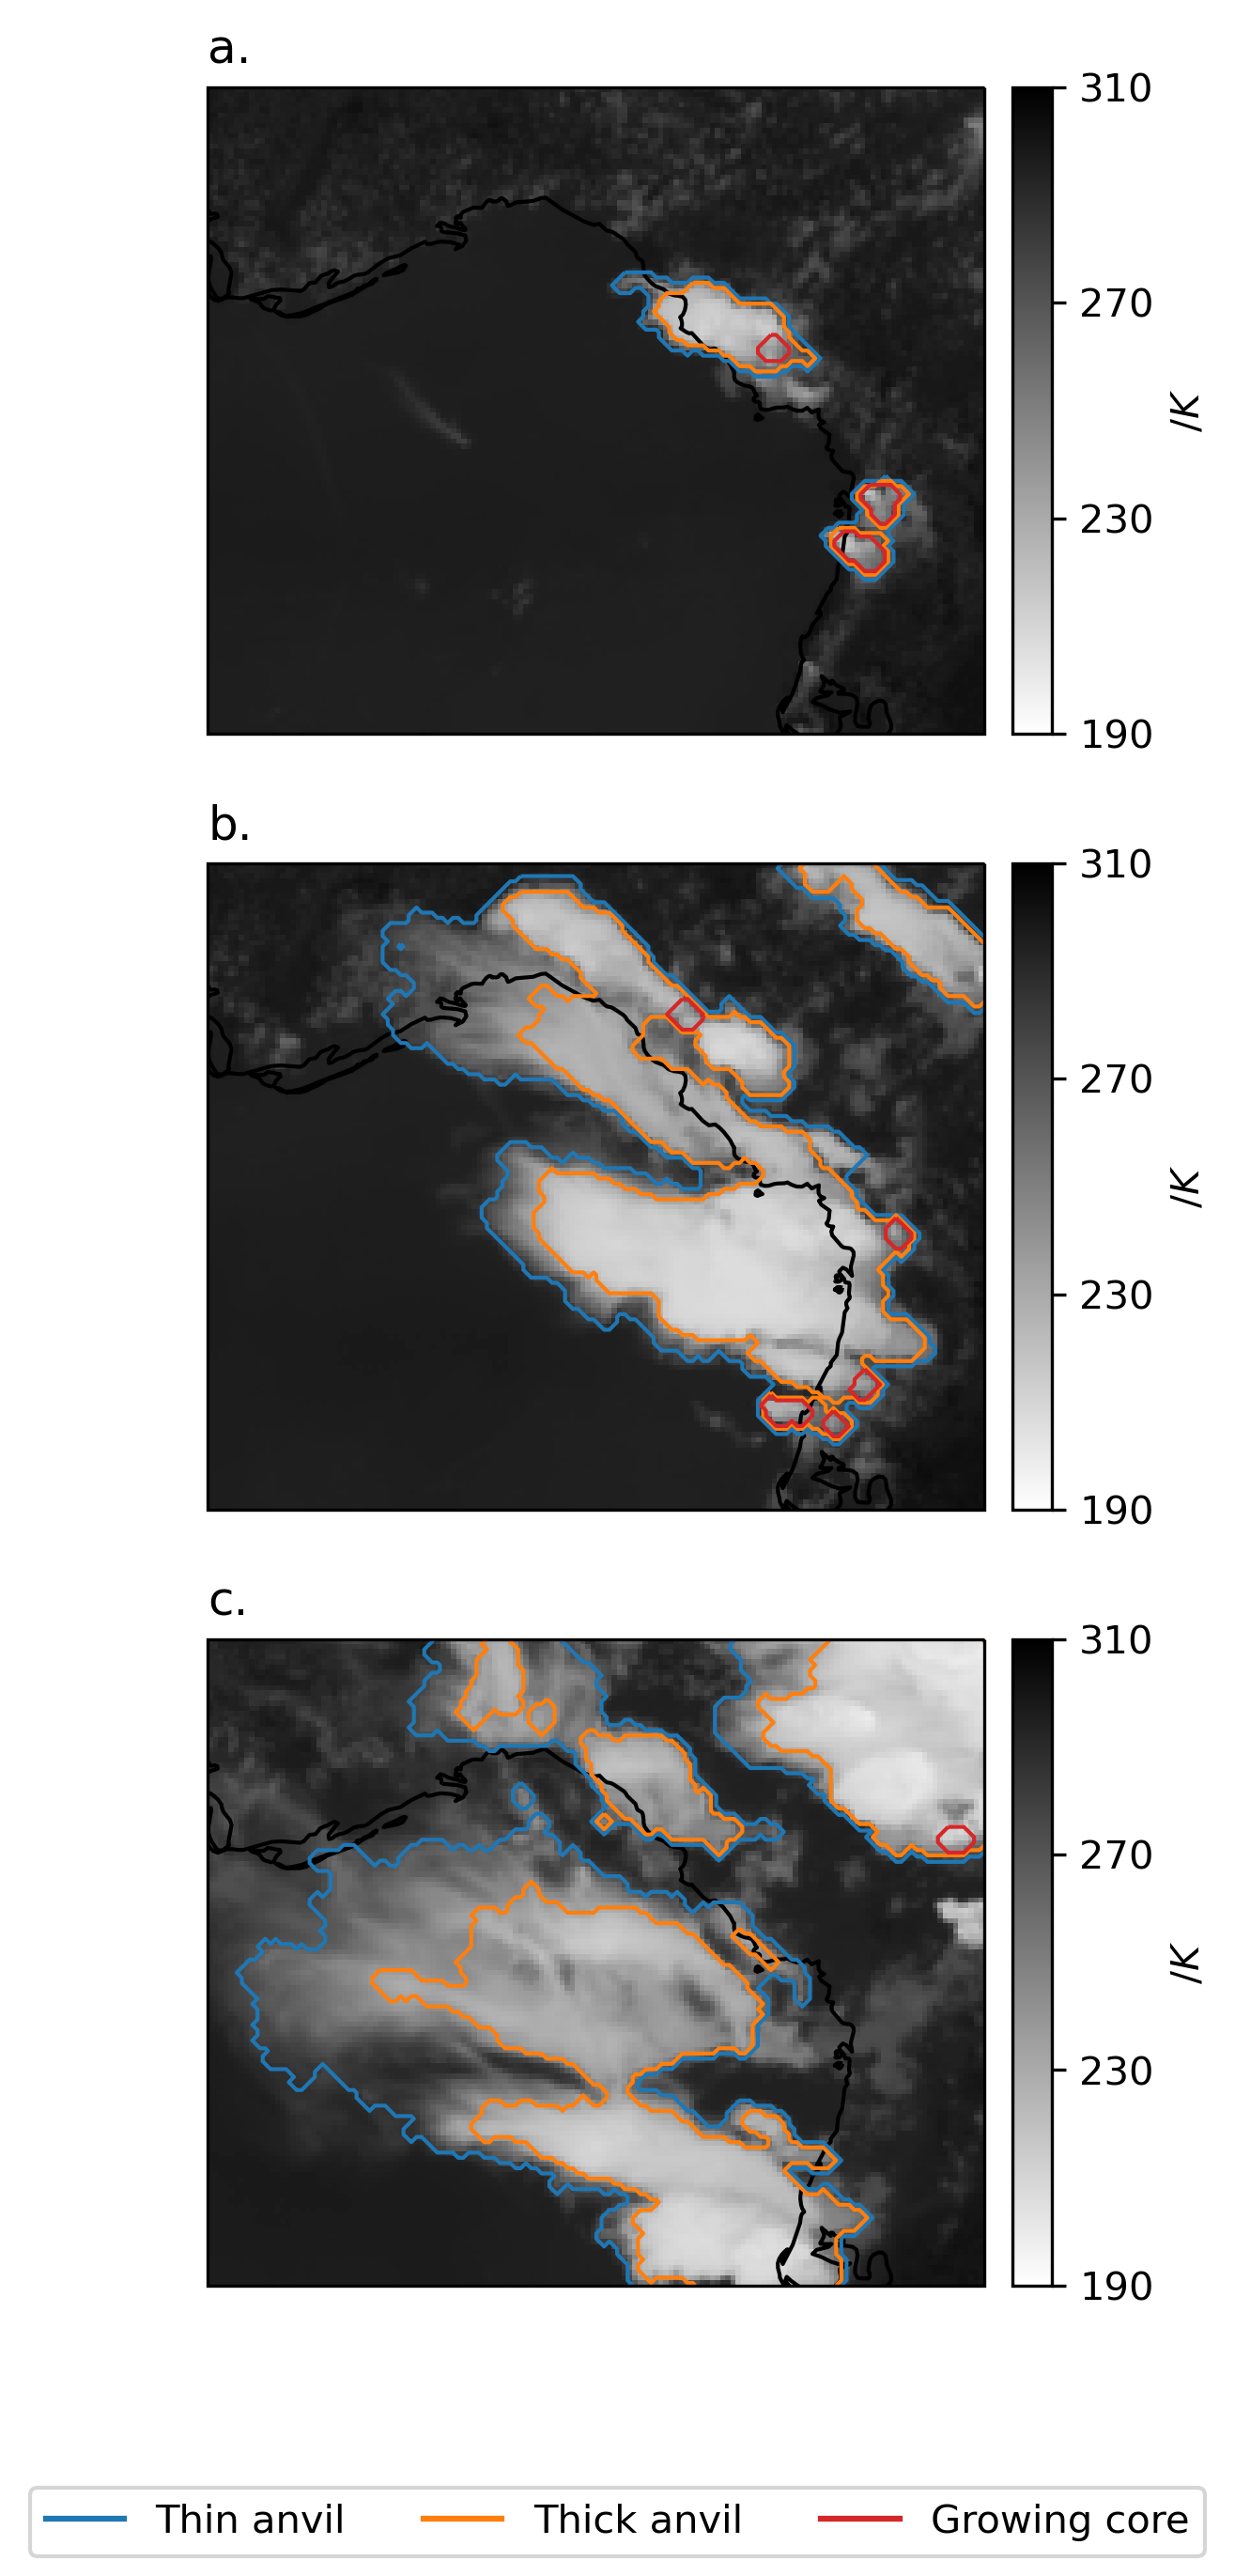

In [227]:
fig = goes_figure(goes_ds, dpi=300, figsize=(4,10))

i1=3
ax1 = fig.subplot(311)
ax1.coastlines()
img = ax1.imshow(goes_ds.CMI_C13[i1], vmin=190, vmax=310, cmap='binary')
cbar = ax1.colorbar(img)
cbar.set_label('/$K$')
cbar.set_ticks([190,230,270,310])
ax1.set_title('a.', loc='left')

ax1.contour(outer_watershed[i1], [0.5], colors=['C00'], linewidths=[1])
ax1.contour(inner_watershed[i1], [0.5], colors=['C01'], linewidths=[1])
ax1.contour(growth_markers[i1], [0.5], colors=['C03'], linewidths=[1])

i2=24
ax2 = fig.subplot(312)
ax2.coastlines()
img = ax2.imshow(goes_ds.CMI_C13[i2], vmin=190, vmax=310, cmap='binary')
cbar = ax2.colorbar(img)
cbar.set_label('/$K$')
cbar.set_ticks([190,230,270,310])
ax2.set_title('b.', loc='left')
ax2.contour(outer_watershed[i2], [0.5], colors=['C00'], linewidths=[1])
ax2.contour(inner_watershed[i2], [0.5], colors=['C01'], linewidths=[1])
ax2.contour(growth_markers[i2], [0.5], colors=['C03'], linewidths=[1])

i3=47
ax3 = fig.subplot(313)
ax3.coastlines()
img = ax3.imshow(goes_ds.CMI_C13[-1], vmin=190, vmax=310, cmap='binary')
cbar = ax3.colorbar(img)
cbar.set_label('/$K$')
cbar.set_ticks([190,230,270,310])
ax3.set_title('c.', loc='left')
ax3.contour(outer_watershed[i3], [0.5], colors=['C00'], linewidths=[1])
ax3.contour(inner_watershed[i3], [0.5], colors=['C01'], linewidths=[1])
ax3.contour(growth_markers[i3], [0.5], colors=['C03'], linewidths=[1])

import matplotlib.lines as mlines
fig.legend([mlines.Line2D([], [], color='C00'), mlines.Line2D([], [], color='C01'), mlines.Line2D([], [], color='C03')], 
           ['Thin anvil', 'Thick anvil', 'Growing core'], loc='lower center', ncol=3)

plt.subplots_adjust(bottom=0.1, hspace=0.2, wspace=0.1)

Figure 9: GLM validation. Histograms of false and missed detections for markers, WVD and detected field

In [43]:
wvd_labels = filter_labels_by_length_and_mask(flow.label(wvd>=-5), wvd.data>=-5, 3)
print("warm WVD regions: n =",wvd_labels.max())

warm WVD regions: n = 10


In [50]:
from utils.validation import get_min_dist_for_objects, get_marker_distance

glm_distance = get_marker_distance(glm_grid)
marker_distance = get_marker_distance(growth_markers)
wvd_distance = get_marker_distance(wvd_labels)
anvil_distance = get_marker_distance(inner_labels)


markers:
n = 17
0.6043541364296081
1.0
WVD:
n = 10
0.9641766176062205
0.8888888888888888
anvil:
n = 2
0.992224382116079
1.0
total GLM flashes:  3601.0


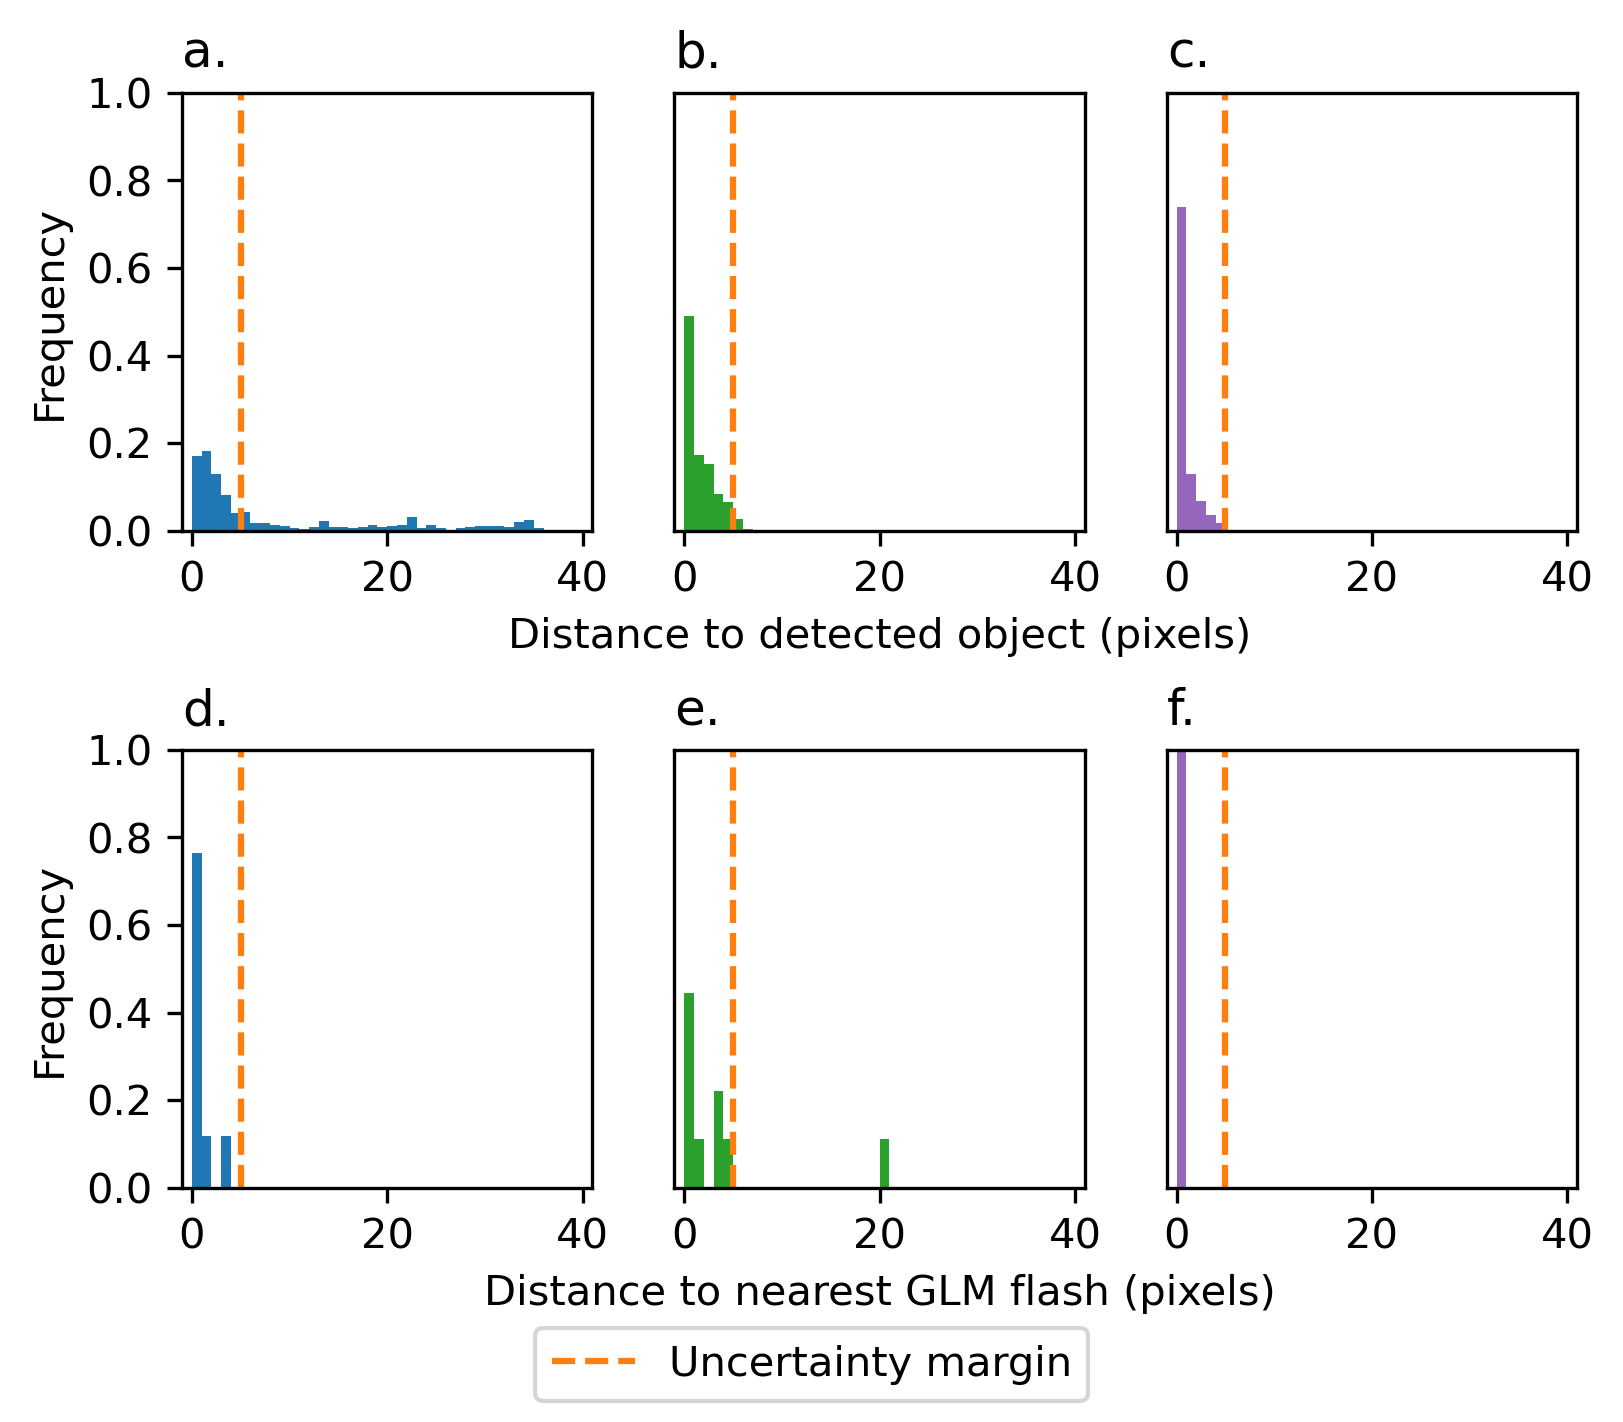

In [52]:
fig = plt.figure(dpi=300, figsize=(6,5))

plt.subplot(231)
h1 = plt.hist(marker_distance[glm_grid>0], 
         weights=glm_grid.data[glm_grid>0], bins=40, range=[0,40], density=True)
plt.plot([5,5],[0,1],c='C01',linestyle='--')
# plt.title('GLM flash distance to nearest marker')
plt.title('a.', loc='left')
plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to marker (pixels)')

plt.subplot(232)
h3 = plt.hist(wvd_distance[glm_grid>0], 
         weights=glm_grid.data[glm_grid>0], bins=40, range=[0,40], density=True, color='C02')
plt.plot([5,5],[0,1],c='C01',linestyle='--')
# plt.title('GLM flash distance to WVD')
plt.title('b.', loc='left')
# plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.yticks([])
plt.xlim([-1,41])
plt.xlabel('Distance to detected object (pixels)')

plt.subplot(233)
h5 = plt.hist(anvil_distance[glm_grid>0], 
         weights=glm_grid.data[glm_grid>0], bins=40, range=[0,40], density=True, color='C04')
plt.plot([5,5],[0,1],c='C01',linestyle='--')
# plt.title('GLM flash distance to nearest anvil')
plt.title('c.', loc='left')
# plt.ylabel('Frequency')
plt.yticks([])
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to detected anvil (pixels)')


plt.subplot(234)
h2 = plt.hist(get_min_dist_for_objects(glm_distance, growth_markers)[0], bins=40, range=[0,40], density=True)
plt.plot([5,5],[0,1],c='C01',linestyle='--')
# plt.title('Marker distance to nearest GLM flash')
plt.title('d.', loc='left')
plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to GLM flash (pixels)')


plt.subplot(235)
h4 = plt.hist(get_min_dist_for_objects(glm_distance, wvd_labels)[0], bins=40, range=[0,40], density=True, color='C02')
plt.plot([5,5],[0,1],c='C01',linestyle='--')
# plt.title('WVD distance to nearest GLM flash')
plt.title('e.', loc='left')
# plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.yticks([])
plt.xlim([-1,41])
plt.xlabel('Distance to nearest GLM flash (pixels)')


plt.subplot(236)
h6 = plt.hist(get_min_dist_for_objects(glm_distance, inner_labels)[0], bins=40, range=[0,40], density=True, color='C04')
plt.plot([5,5],[0,1],c='C01',linestyle='--')
# plt.title('Anvil distance to nearest GLM flash')
plt.title('f.', loc='left')
# plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.yticks([])
plt.xlim([-1,41])
# plt.xlabel('Distance to GLM flash (pixels)')

fig.legend([mlines.Line2D([], [], color='C01', linestyle='--')], 
           ['Uncertainty margin'], loc='lower center')

plt.subplots_adjust(hspace=0.5, bottom=0.15)

print('markers:')
print('n =', growth_markers.data.max())
print(np.sum(h1[0][:5]))
print(np.sum(h2[0][:5]))

print('WVD:')
print('n =', wvd_labels.max())
print(np.sum(h3[0][:5]))
print(np.sum(h4[0][:5]))

print('anvil:')
print('n =', inner_labels.max())
print(np.sum(h5[0][:5]))
print(np.sum(h6[0][:5]))

print('total GLM flashes: ', np.sum(glm_grid.data))
